In [31]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import contractions
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
import seaborn as sn
from matplotlib import pyplot as plt
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras import callbacks
%matplotlib inline

In [64]:
df = pd.read_csv('clean_train.csv')
df.head()

,Unnamed: 0,id,title,author,text,label,articles
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman campus breitb...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired truth might get fired oc...
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 civilian killed single u airstrike identifi...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jailed fictional unpublished sto...


Take Y from labels column

In [65]:
y = df['label']

In [5]:
y.shape

(20761,)

Take input from 'articles columns'

In [66]:
x = df['articles']

In [7]:
x.shape

(20761,)

Find maximum length article

In [67]:
x.map(lambda x: len(x)).max()

85593

Vectorization of input using TFidf Vectorizer

In [68]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

In [69]:
count_vectorizer.fit_transform(x)

<20761x177500 sparse matrix of type '<class 'numpy.int64'>'
	with 5851194 stored elements in Compressed Sparse Row format>

In [70]:
freq_term_matrix = count_vectorizer.transform(x)

In [71]:
pickle.dump(count_vectorizer.vocabulary_,open("feature.pkl","wb"))

In [72]:
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [73]:
tf_idf_matrix.shape

(20761, 177500)

Split data in train and validation

In [74]:
x_train, x_val, y_train, y_val = train_test_split(tf_idf_matrix,y, random_state=0)

In [75]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(15570, 177500)
(5191, 177500)
(15570,)
(5191,)


As this is a binary classification model, we can use simple logistic regression

In [76]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train)
accuracy = logistic_model.score(x_val, y_val)

In [77]:
print(accuracy*100)

96.01232903101521


In [78]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_val, logistic_model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2636
           1       0.95      0.97      0.96      2555

    accuracy                           0.96      5191
   macro avg       0.96      0.96      0.96      5191
weighted avg       0.96      0.96      0.96      5191



In [79]:
y_predicted_logistic = logistic_model.predict(x_val)
y_predicted_logistic

array([0, 0, 0, ..., 0, 0, 1])

View Confusion Matrix

Text(69.0, 0.5, 'Truth')

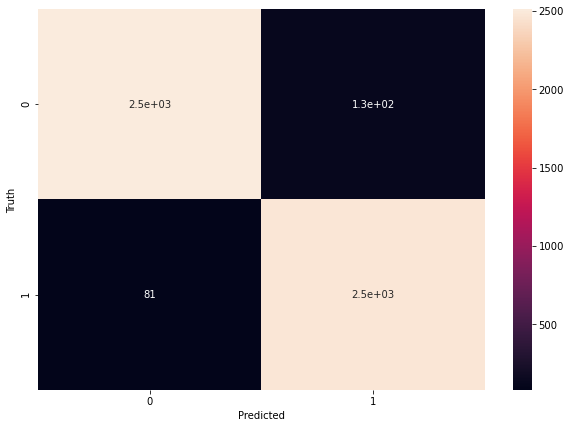

In [80]:
cm = confusion_matrix(y_val, y_predicted_logistic)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [81]:
from sklearn.metrics import roc_auc_score
auc_score_logistic = roc_auc_score(y_val, y_predicted_logistic)
auc_score_logistic

0.9602488797294126

In [82]:
fpr_logistic, tpr_logistic, thresh_logistic = roc_curve(y_val, y_predicted_logistic, pos_label=1)

Test with Naive Bayes Model

In [83]:
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
nb_accuracy = nb_model.score(x_val, y_val)
print(nb_accuracy*100)

85.87940666538239


In [84]:
print(classification_report(y_val, nb_model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      2636
           1       0.99      0.72      0.83      2555

    accuracy                           0.86      5191
   macro avg       0.89      0.86      0.86      5191
weighted avg       0.89      0.86      0.86      5191



In [85]:
y_predicted_nb = nb_model.predict(x_val)
y_predicted_nb

array([0, 0, 0, ..., 0, 0, 0])

Text(69.0, 0.5, 'Truth')

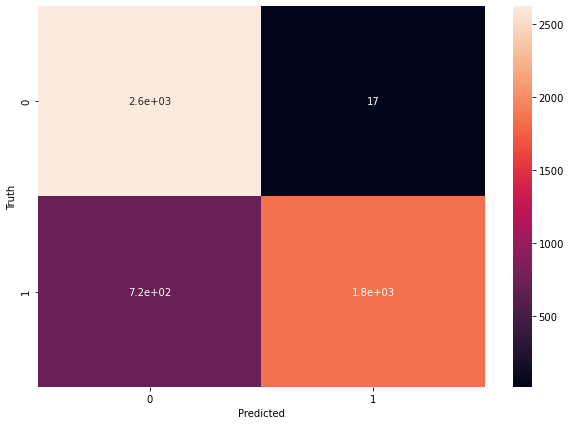

In [86]:
cm = confusion_matrix(y_val, y_predicted_nb)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [87]:
auc_score_nb = roc_auc_score(y_val, y_predicted_nb)
auc_score_nb

0.856658000469192

In [88]:
fpr_nb, tpr_nb, thresh_nb = roc_curve(y_val, y_predicted_nb, pos_label=1)

In [89]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)
rf_accuracy = rf_model.score(x_val, y_val)
print(rf_accuracy*100)

93.18050471970719


In [90]:
print(classification_report(y_val, rf_model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.93      2636
           1       0.96      0.90      0.93      2555

    accuracy                           0.93      5191
   macro avg       0.93      0.93      0.93      5191
weighted avg       0.93      0.93      0.93      5191



In [91]:
y_predicted_rf = rf_model.predict(x_val)
y_predicted_rf

array([0, 0, 0, ..., 0, 0, 0])

Text(69.0, 0.5, 'Truth')

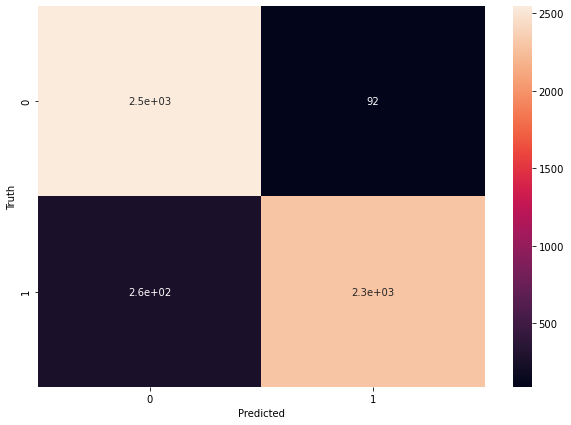

In [92]:
cm = confusion_matrix(y_val, y_predicted_rf)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [93]:
auc_score_rf = roc_auc_score(y_val, y_predicted_rf)
auc_score_rf

0.9312773014916155

In [94]:
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_val, y_predicted_rf, pos_label=1)

After analysing 3 models above. logistic regression is giving best results in terms of accuracy, precision , recall as well as f1 score and also after looking after ROC curve plot.

In [95]:
df_test = pd.read_csv('clean_test.csv')
df_test.head()

,Unnamed: 0,id,title,author,text,articles
0,0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",specter trump loosens tongues purse strings si...
1,1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,russian warship ready strike terrorist near al...
2,2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,nodapl native american leader vow stay winter ...
3,3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",tim tebow attempt another comeback time baseba...
4,4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,keiser report meme war e995 42 min ago 1 view ...


In [96]:
test_articles = df_test['articles']
test_articles

0       specter trump loosens tongues purse strings si...
1       russian warship ready strike terrorist near al...
2       nodapl native american leader vow stay winter ...
3       tim tebow attempt another comeback time baseba...
4       keiser report meme war e995 42 min ago 1 view ...
                              ...                        
5188    bangladeshi traffic jam never end  new york ti...
5189    john kasich sign one abortion bill ohio veto r...
5190    california today what exactly sushi  new york ...
5191    300 u marine deployed russian border norway pr...
5192    awkward sex onscreen  new york time perhaps se...
Name: articles, Length: 5193, dtype: object

In [97]:
test_articles.shape

(5193,)

In [98]:
#tf_idf_matrix_test = tfidf.fit_transform(count_vectorizer.fit_transform(test_articles))
loaded_feature_vector = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("feature.pkl", "rb")))
tf_idf_matrix_test = tfidf.fit_transform(loaded_feature_vector.fit_transform(test_articles))


In [99]:
tf_idf_matrix_test.shape

(5193, 177500)

In [100]:
x_val.shape

(5191, 177500)

In [101]:
tf_idf_matrix_test.shape

(5193, 177500)

In [102]:
test_preds = logistic_model.predict(tf_idf_matrix_test)
test_preds.shape

(5193,)

In [103]:
preds_df = pd.DataFrame(test_preds,columns = ['label'])

In [104]:
df_test['labels'] = preds_df

In [105]:
df_test.head()

,Unnamed: 0,id,title,author,text,articles,labels
0,0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",specter trump loosens tongues purse strings si...,0
1,1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,russian warship ready strike terrorist near al...,1
2,2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,nodapl native american leader vow stay winter ...,1
3,3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",tim tebow attempt another comeback time baseba...,0
4,4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,keiser report meme war e995 42 min ago 1 view ...,1


In [88]:
submit_df = df_test.drop(['title','author','text','articles'], axis=1)
submit_df.drop(submit_df.columns[0],axis = 1,inplace = True)
submit_df.head()

,id,labels
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [89]:
submit_df.to_csv('output_submit.csv')

LSTM Approach

In [5]:
df_lstm = pd.read_csv('clean_train.csv')
df_lstm.head()

,Unnamed: 0,id,title,author,text,label,articles
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman campus breitb...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired truth might get fired oc...
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 civilian killed single u airstrike identifi...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jailed fictional unpublished sto...


In [6]:
Y =df_lstm['label']

In [7]:
X = df_lstm['articles']

In [8]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 15,stratify = Y)

In [9]:
tokenizer = Tokenizer()
len(X)

20761

In [10]:
tokenizer.fit_on_texts(X)

In [11]:
vocab_size = len(tokenizer.word_index)+1

In [12]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [52]:
maxlen = 200
embiding_dim = 128

In [14]:
X_train_pad = pad_sequences(X_train_tokens, maxlen = maxlen,padding = 'post' )
X_test_pad = pad_sequences(X_test_tokens, maxlen = maxlen,padding = 'post' )

In [15]:
X_train_pad.shape

(16608, 200)

In [109]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embiding_dim),
   tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embiding_dim)),
    #tf.keras.layers.Dense(embiding_dim,activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    #tf.keras.layers.Dense(embiding_dim,activation = 'relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
    
])
tbcallback = tf.keras.callbacks.TensorBoard(log_dir = './logs',histogram_freq = 0,write_graph = True,write_images =True)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         22724736  
                                                                 
 dropout_15 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 22,988,161
Trainable params: 22,988,161
Non-trainable params: 0
__________________________________________

In [58]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True)

In [59]:
model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = 'accuracy')

In [60]:
num_epochs = 20

In [61]:
model.fit(X_train_pad,Y_train,batch_size = 64,epochs = num_epochs, validation_data = (X_test_pad,Y_test),verbose = 2, callbacks = [tbcallback,earlystopping])

Epoch 1/20
260/260 - 110s - loss: 0.3015 - accuracy: 0.8748 - val_loss: 0.1305 - val_accuracy: 0.9514 - 110s/epoch - 425ms/step
Epoch 2/20
260/260 - 109s - loss: 0.0356 - accuracy: 0.9896 - val_loss: 0.0766 - val_accuracy: 0.9709 - 109s/epoch - 419ms/step
Epoch 3/20
260/260 - 109s - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0854 - val_accuracy: 0.9730 - 109s/epoch - 421ms/step
Epoch 4/20
260/260 - 108s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0928 - val_accuracy: 0.9754 - 108s/epoch - 417ms/step
Epoch 5/20
260/260 - 109s - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0913 - val_accuracy: 0.9733 - 109s/epoch - 419ms/step


In [62]:
y_pred_float = model.predict(X_test_pad)
y_pred = []
for pred in y_pred_float:
    if(pred>0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2078
           1       0.97      0.97      0.97      2075

    accuracy                           0.97      4153
   macro avg       0.97      0.97      0.97      4153
weighted avg       0.97      0.97      0.97      4153

